In [1]:
# Study of the effect of temperature and soot thickness  on the antenna frequencies
# Using Sci-kit Learn to validate performance from previous code
# See publication: Microstrip patch antenna for simultaneous temperature sensing and superstrate characterization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

In [3]:
np.set_printoptions(precision=6)
np.random.seed(42)

In [4]:
# Load data
df = pd.read_csv('T_h_ff_data.csv')

In [5]:
df.head(5)

,Temperature,Superstrate_thickness,Frequency10,Frequency01
0,22.980204,0,2.549826,3.293016
1,23.159179,0,2.549910,3.293125
2,22.926659,0,2.549801,3.292983
3,22.923294,0,2.549799,3.292981
4,22.968323,0,2.549820,3.293008


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875000 entries, 0 to 874999
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Temperature            875000 non-null  float64
 1   Superstrate_thickness  875000 non-null  int64  
 2   Frequency10            875000 non-null  float64
 3   Frequency01            875000 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 26.7 MB


In [7]:
df.describe()

,Temperature,Superstrate_thickness,Frequency10,Frequency01
count,875000.000000,875000.000000,875000.000000,875000.000000
mean,84.406420,785.714286,2.539524,3.281933
std,36.136104,523.282718,0.026830,0.032525
min,22.672287,0.000000,2.489885,3.224244
25%,54.394810,280.000000,2.519034,3.256539
50%,84.559952,770.000000,2.537681,3.279709
75%,114.465955,1270.000000,2.557569,3.303040
max,144.800752,1600.000000,2.607203,3.367298


In [8]:
# Domain knowledge: Sooth thickness and temperature changes affect both sensor frequencies. The sensor resonates at two
# frequencies f10 and f01. There are two inputs (Superstrate_thickness and temperature) and two outputs (f10 and f01)
h = df['Superstrate_thickness']
T = df['Temperature'] 
f10 = df['Frequency10']
f01 = df['Frequency01']

In [9]:
X = np.c_[T, h]  # Features
Y = np.c_[f10, f01]  # Targets

Text(0.5, 0.98, 'Sensor frequencies vs. soot and temperature')

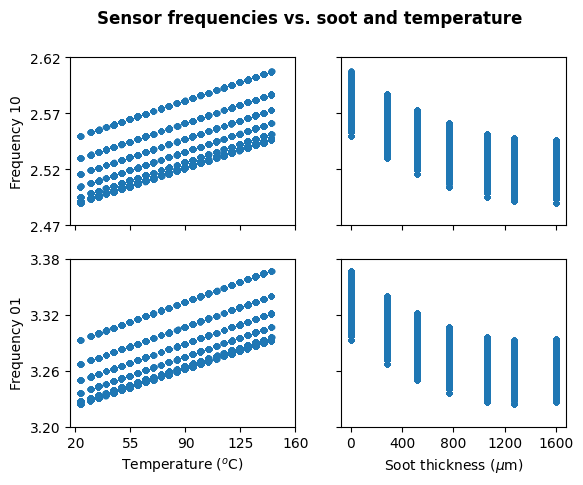

In [10]:
# Visualizing data
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')

for j in range(2):
    for i in range(len(ax)):
        ax[j, i].scatter(X[:, i], Y[:, j], s=10)

ax[1, 0].set_xlabel('Temperature ($^o$C)')
ax[1, 1].set_xlabel('Soot thickness ($\\mu$m)')
ax[0, 0].set_ylabel('Frequency 10')
ax[1, 0].set_ylabel('Frequency 01')

ax[1, 0].set_xticks(np.linspace(20, 160, 5))
ax[1, 1].set_xticks(np.linspace(0, 1600, 5))
ax[0, 0].set_yticks(np.linspace(2.47, 2.62, 4))
ax[1, 0].set_yticks(np.linspace(3.2, 3.38, 4))

# plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Sensor frequencies vs. soot and temperature', weight='bold')

In [11]:
# As shown and from knowledge of previous studies, the frequencies are linear functions of the temperature.
# At constant sooth thickness, the frequencies increase linearly with temperature change. At constant 
# temperature, the best fit for soot thickness is a second-order polynomial. We need feature engineering.

# Feature engineering
X_mapped = np.c_[h, h ** 2, T * h, T]


In [12]:
#  Data split and feature scaling
X_train_mapped, X_test_mapped, Y_train, Y_test = train_test_split(X_mapped, Y, train_size=0.9, random_state=42)

scaler = StandardScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)

print(f"Peak to Peak range by column in raw training set:{np.ptp(X_train_mapped, axis=0)}")
print(f"Peak to Peak range by column in normalized training set:{np.ptp(X_train_mapped_scaled, axis=0)}")

Peak to Peak range by column in raw training set:[1.600000e+03 2.560000e+06 2.315252e+05 1.221285e+02]
Peak to Peak range by column in normalized training set:[3.05707  2.944237 4.147599 3.379336]


In [13]:
# Define the model
model = MultiOutputRegressor(LinearRegression())

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = cross_validate(model, X_train_mapped_scaled, Y_train, cv=cv, return_estimator=True, scoring=['neg_mean_squared_error', 'r2'])

In [14]:
cv_results

{'fit_time': array([0.10922 , 0.261951, 0.282255, 0.399245, 0.250841]),
 'score_time': array([0.04829 , 0.069914, 0.043507, 0.096065, 0.071994]),
 'estimator': [MultiOutputRegressor(estimator=LinearRegression()),
  MultiOutputRegressor(estimator=LinearRegression()),
  MultiOutputRegressor(estimator=LinearRegression()),
  MultiOutputRegressor(estimator=LinearRegression()),
  MultiOutputRegressor(estimator=LinearRegression())],
 'test_neg_mean_squared_error': array([-8.328394e-20, -8.317377e-20, -8.318237e-20, -8.355458e-20,
        -8.308943e-20]),
 'test_r2': array([1., 1., 1., 1., 1.])}

In [15]:
best_index = np.argmax(cv_results['test_r2'])
best_estimator = cv_results['estimator'][best_index]
best_estimator.fit(X_train_mapped_scaled, Y_train)
Cost_train = mse(Y_train, best_estimator.predict(X_train_mapped_scaled)) / 2
Cost_test = mse(Y_test, best_estimator.fit(X_train_mapped_scaled, Y_train).predict(X_test_mapped_scaled)) / 2

print("Training loss: ", Cost_train)
print("Test loss: ", Cost_test)

Training loss:  4.162770032854798e-20
Test loss:  4.183898079218954e-20


In [16]:
# Evaluate the model
individual_train_scores = []
individual_test_scores = []

# Calculate the score for each target variable separately
individual_train_scores = r2(Y_train, best_estimator.predict(X_train_mapped_scaled), multioutput='raw_values')
individual_test_scores = r2(Y_test, best_estimator.predict(X_test_mapped_scaled), multioutput='raw_values')

In [17]:
print(f"Training scores for each target: {np.array(individual_train_scores)}")
print(f"Test scores for each target: {np.array(individual_test_scores)}")

Training scores for each target: [1. 1.]
Test scores for each target: [1. 1.]


In [18]:
# Extract the trained base regressors from MultiOutputRegressor
base_final = best_estimator.estimators_
W = np.array([regressor.coef_ for regressor in base_final])  
b = np.array([regressor.intercept_ for regressor in base_final])

In [19]:
print("Training cost: %e, Test cost: %e" % (Cost_train, Cost_test))
print(f"Model score: {best_estimator.score(X_test_mapped_scaled, Y_test)}")
print(f"W: {W}")
print(f"b: {b}")

Training cost: 4.162770e-20, Test cost: 4.183898e-20
Model score: 0.9999999999999999
W: [[-0.041326  0.022676 -0.000371  0.017025]
 [-0.053646  0.033832 -0.002261  0.022042]]
b: [2.539521 3.28193 ]


In [20]:
# Final note: If you do not have domain knowledge, you can apply feature engineering to a higher polynomial order. 
# Then, apply regularization if needed. If you would like to know how this was done in previous studies to aid in 
# the selection of the current features, check out my previous work on the effect of temperature on the antenna 
# frequencies and the effect of soot/superstrate thickness on the antenna frequencies.
# Thanks.